In [54]:
import os
import numpy as np
import pandas as pd
import pickle
from preprocessing_helper import *

### 1. Get directories related information and load in MoonBoard 2016 data

In [61]:
cwd = os.getcwd()
parent_wd = cwd.replace('/preprocessing', '')
raw_data_path = parent_wd + '/raw_data/moonGen_scrape_2016_final'
hold_feature_path = parent_wd + '/raw_data/HoldFeature2016.csv'

In [62]:
with open(raw_data_path, 'rb') as f:
    MoonBoard_2016_raw = pickle.load(f)

In [57]:
features = pd.read_csv(hold_feature_path, dtype=str)

# convert features from pd dataframe to dictionary
feature_dict = {}
for index in features.index:
    feature_item = features.loc[index]
    feature_dict[(int(feature_item['X_coord']), int(feature_item['Y_coord']))] = np.array(
        list(feature_item['Difficulties'])).astype(int)

### 2. Separate data into different categories:
- no user ratings
- benchmarked with user ratings
- non-benchmarked with user ratings

In [58]:
def classify_and_reorganize_data(raw_data, save_path, delta_xy_mode = False, print_result = False):
    """
    Input:
    - raw_data: the raw data that is scraped from MoonBoard
    - delta_xy_mode: 
      if set False(default), the x_vector compiled will be of shape (10, n_holds) (6 hold features, x, y, is_start, is_end)
      if set True, the x_vector compiled will be of shape (14, n_holds) (6 hold features, x, y, dx1, dy1, dx2, dy2, is_start, is_end)
    
    Classify and process the raw data into 4 caterogies/8 dictionaries:
    - X_dict_benchmark_withgrade: the input data that is benchmarked and contains user grading.
    - Y_dict_benchmark_withgrade: the output for raw data that is benchmarked and contains user grading.
    - X_dict_benchmark_nograde: the input data that is benchmarked and does not contain user grading.
    - Y_dict_benchmark_nograde: the output for raw data that is benchmarked and does not contain user grading.
    - X_dict_withgrade: the input data that is not benchmarked and contains user grading.
    - Y_dict_withgrade: the output for raw data that is not benchmarked and contains user grading.
    - X_dict_nograde: the input data that is not benchmarked and does not contain user grading.
    - Y_dict_nograde: the output for raw data that is not benchmarked and does not contain user grading.
    For the ones that do not have user grading, the shape of each item in Y_dict is (2, 1): (grade, is_benchmarked)
    For the ones that have user grading, the shape of each item in Y_dict is (3, 1): (grade, is_benchmarked, user_grade)
    """
    X_dict_benchmark_withgrade = {}
    Y_dict_benchmark_withgrade = {}
    X_dict_benchmark_nograde = {}
    Y_dict_benchmark_nograde = {}
    X_dict_withgrade = {}
    Y_dict_withgrade = {}
    X_dict_nograde = {}
    Y_dict_nograde = {}
    list_fail = []
    for key, item in raw_data.items():
        # create x_vector
        try:
            n_start = len(item['start'])
            n_mid = len(item['mid'])
            n_end = len(item['end'])
            
            assert(n_start <= 2)
            assert(n_end <= 2)
            
            n_hold = n_start + n_mid + n_end
            item['start'].sort(key = lambda x: x[1])
            item['mid'].sort(key = lambda x: x[1])
            item['end'].sort(key = lambda x: x[1])
            combined_list = item['start'] + item['mid'] + item['end']

            if delta_xy_mode:
                x_vectors = np.zeros((14, n_hold))
                for i, (x, y) in enumerate(combined_list):
                    x_vectors[0:6, i] = feature_dict[(x, y)] # 6 hand features
                    x_vectors[6:8, i] = [x, y] #(x, y)
                    if i == 0:
                        pass
                    elif i == 1:
                        x_vectors[8:10, i] = x_vectors[6:8, i] - x_vectors[6:8, i-1]
                    else:
                        x_vectors[8:10, i] = x_vectors[6:8, i] - x_vectors[6:8, i-1]
                        x_vectors[10:12, i] = x_vectors[6:8, i] - x_vectors[6:8, i-2]
                x_vectors[12:, 0:n_start] = np.array([[1], [0]])
                x_vectors[12:, n_start+n_mid:] = np.array([[0], [1]])

            else:
                x_vectors = np.zeros((10, n_hold))
                for i, (x, y) in enumerate(combined_list):
                    x_vectors[0:6, i] = feature_dict[(x, y)] # 6 hand features
                    x_vectors[6:8, i] = [x, y] #(x, y)
                x_vectors[8:, 0:n_start] = np.array([[1], [0]])
                x_vectors[8:, n_start+n_mid:] = np.array([[0], [1]])

            # save x_vector into the correct dictionary
            if item['is_benchmark']:
                if item['user_grade'] is None:
                    X_dict_benchmark_nograde[key] = x_vectors
                    Y_dict_benchmark_nograde[key] = np.array([[grade_map[item['grade']]], 
                                                                [int(item['is_benchmark'])]])
                else:
                    X_dict_benchmark_withgrade[key] = x_vectors
                    Y_dict_benchmark_withgrade[key] = np.array([[grade_map[item['grade']]], 
                                                                [int(item['is_benchmark'])], 
                                                                [grade_map[item['user_grade']]]])
            elif item['user_grade'] is None:
                X_dict_nograde[key] = x_vectors
                Y_dict_nograde[key] = np.array([[grade_map[item['grade']]], 
                                                  [int(item['is_benchmark'])]])
            else:
                X_dict_withgrade[key] = x_vectors
                Y_dict_withgrade[key] = np.array([[grade_map[item['grade']]], 
                                                  [int(item['is_benchmark'])],
                                                  [grade_map[item['user_grade']]]])
            if print_result:
                print('Complete processing of %s' %key)
            
        except:
            print('Raw data with key %s contains error' %key)
            list_fail.append(key)

    output = {'X_dict_benchmark_withgrade': X_dict_benchmark_withgrade,
              'Y_dict_benchmark_withgrade': Y_dict_benchmark_withgrade, 
              'X_dict_benchmark_nograde': X_dict_benchmark_nograde, 
              'Y_dict_benchmark_nograde': Y_dict_benchmark_nograde, 
              'X_dict_withgrade': X_dict_withgrade, 
              'Y_dict_withgrade': Y_dict_withgrade, 
              'X_dict_nograde': X_dict_nograde, 
              'Y_dict_nograde': Y_dict_nograde, 
              'list_fail': list_fail}
    
    save_pickle(output, save_path)
    print('result saved.')
    return output

In [59]:
grade_map = get_grade_map()

In [181]:
output_xy_mode['list_fail']

['307940',
 '307837',
 '307748',
 '307711',
 '307661',
 '307602',
 '307599',
 '304387']

In [60]:
save_path = cwd + '/processed_data_deltaxy_mode'
output_deltaxy_mode = classify_and_reorganize_data(MoonBoard_2016_raw, save_path, delta_xy_mode = True)

Raw data with key 307940 contains error
Raw data with key 307837 contains error
Raw data with key 307748 contains error
Raw data with key 307711 contains error
Raw data with key 307661 contains error
Raw data with key 307602 contains error
Raw data with key 307599 contains error
Raw data with key 304387 contains error
result saved.


In [187]:
save_path = cwd + '/processed_data_xy_mode'
output_xy_mode = classify_and_reorganize_data(MoonBoard_2016_raw, save_path, delta_xy_mode = False)

Raw data with key 307940 contains error
Raw data with key 307837 contains error
Raw data with key 307748 contains error
Raw data with key 307711 contains error
Raw data with key 307661 contains error
Raw data with key 307602 contains error
Raw data with key 307599 contains error
Raw data with key 304387 contains error
result saved.


In [53]:
X_dict_merge['337609']

array([[ 0.,  0.,  0.,  1.,  1.,  2.],
       [ 2.,  1.,  2.,  0.,  4.,  6.],
       [ 4.,  5.,  7.,  1.,  4.,  8.],
       [ 2.,  1.,  2.,  5.,  4.,  6.],
       [ 0.,  0.,  0.,  2.,  1.,  2.],
       [ 3.,  0.,  0.,  0.,  0.,  0.],
       [ 8., 10.,  7.,  7.,  4.,  3.],
       [ 4.,  8., 10., 13., 15., 17.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

### 3. Data Preprocessing with sequence generator

In [6]:
raw_data_forseq_path = parent_wd + '/preprocessing/processed_data_xy_mode'
with open(raw_data_forseq_path, 'rb') as f:
    MoonBoard_2016_raw_forseq = pickle.load(f)

In [9]:
X_dict_merge = {**MoonBoard_2016_raw_forseq['X_dict_benchmark_withgrade'], 
                **MoonBoard_2016_raw_forseq['X_dict_benchmark_nograde'], 
                **MoonBoard_2016_raw_forseq['X_dict_withgrade'], 
                **MoonBoard_2016_raw_forseq['X_dict_nograde']}
Y_dict_merge = {**MoonBoard_2016_raw_forseq['Y_dict_benchmark_withgrade'], 
                **MoonBoard_2016_raw_forseq['Y_dict_benchmark_nograde'], 
                **MoonBoard_2016_raw_forseq['Y_dict_withgrade'], 
                **MoonBoard_2016_raw_forseq['Y_dict_nograde']}

In [45]:
def generate_organized_sequence_data(raw_data, save_path):
    """
    Input:
    - raw_data: the raw data that is scraped from MoonBoard
    - delta_xy_mode: 
      if set False(default), the x_vector compiled will be of shape (10, n_holds) (6 hold features, x, y, is_start, is_end)
      if set True, the x_vector compiled will be of shape (14, n_holds) (6 hold features, x, y, dx1, dy1, dx2, dy2, is_start, is_end)
    
    Classify and process the raw data into 2 dictionaries:
    - X_dict
    - Y_dict
    """
    X_dict_seq = {}
    list_fail = []
    for key, item in raw_data.items():
        try:
            output = produce_sequence(keyNum = key, X_dict = raw_data, n_return = 1)
            result = np.vstack([
                raw_data[key][6:8, output[0].handSequence], 
                (np.array(output[0].handOperator) == 'LH')*(-1) + (np.array(output[0].handOperator) == 'RH')*1, 
                output[0].successScoreSequence])
            X_dict_seq[key] = result
        except:
            print('data with key %s contains error' %key)
            list_fail.append(key)
        
        save_pickle(X_dict_seq, save_path)

    final_output = {'X_dict_seq': X_dict_seq,
              'list_fail': list_fail}
    
    save_pickle(X_dict_seq, save_path)
    print('result saved.')
    return final_output

In [ ]:
save_path_seq = cwd + '/processed_data_seq'
output_seq = generate_organized_sequence_data(raw_data = X_dict_merge, save_path = save_path_seq)

After Beamer search, the most possible hand sequence and the successRate:
[0, 0, 1, 2, 3, 4, 5] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH'] 229.17442900816357
[13.966610165238235, 3.771272258651297, 3.462239147685987, 4.2965295841566284, 1.0226156288345547, 9.826095003804213, 40.82321619767785]
After Beamer search, the most possible hand sequence and the successRate:
[0, 0, 1, 2, 3, 4, 5] ['LH', 'RH', 'LH', 'RH', 'RH', 'LH', 'RH'] 25.662714212807135
[17.769336928223957, 8.89216531778502, 1.8701731248530076, 0.08932942698730434, 5.863121552017952, 1.4618647551633823, 8.585814486631532]
After Beamer search, the most possible hand sequence and the successRate:
[0, 1, 3, 4, 5, 6] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH'] 515.7494242864443
[13.966610165238235, 0.2998804229301691, 8.806838882687279, 22.23281394481997, 12.580977395651514, 25.78157891381218]
After Beamer search, the most possible hand sequence and the successRate:
[0, 0, 2, 3, 4] ['LH', 'RH', 'LH', 'RH', 'LH'] 121.18568122292079
[17

In [49]:
len(output_seq['X_dict_seq'])

30557

In [50]:
save_path_seq

'/Users/jrchang612/MoonBoardRNN/preprocessing/processed_data_seq'

In [51]:
save_pickle(output_seq, save_path_seq)

In [87]:
repeats_statistics = []
for keys, values in MoonBoard_2016_raw.items():
    repeats_statistics.append(values['repeats'])

In [115]:
author_dictionary = {}
for keys, values in MoonBoard_2016_raw.items():
    author = values['setter']['Nickname']
    if author in author_dictionary:
        author_dictionary[author] += 1
    else:
        author_dictionary[author] = 1

In [135]:
author_dictionary['Adan_vive']

364

In [126]:
benchmark_author_dictionary = {}
for keys, values in MoonBoard_2016_raw.items():
    if values['is_benchmark']:
        author = values['setter']['Nickname']
        if author in benchmark_author_dictionary:
            benchmark_author_dictionary[author] += 1
        else:
            benchmark_author_dictionary[author] = 1

In [152]:
benchmark_author_problem_sum = 0
for keys in benchmark_author_dictionary:
    print(author_dictionary[keys])
    benchmark_author_problem_sum += author_dictionary[keys]

61
82
17
63
13
9
23
52
13
100
164
296
120
106
110
43
1
5
22
17
100
9
329
6
53
2
48
1
6
1
6
179
14
1
5
2
1
1
1
13
3
1
7
27
18
64
35
9
1
4
13
309
11
10
30
43
4
2
27
2
1
1
3
120
9
90
10
4
11
8
1
3
2
10
10
6
1
2
5
9
7
1
3
1
1
11
1
2
19
4
23
1
1
29
8
35
3
1
7
61
32
1
16
1
36
6
1
15
12
8
1
11
10
5
1
30
4
67
1
2
14
8
1
1
1
19
1
14
1
74
2
6
10
4
1
48
9
1
12
19
16
1
1
17
2
1
11
13
1
11
25
1
46
3
10
9
2
1
1
3
28
1
9
1
4
8
1
45
3
1
4
10
46
10
21
16
1
23
5
3
2
5
12
1
31
30
2
2
8
17
16
26
22
23
19


In [137]:
sorted_author_list = sorted(author_dictionary, key = author_dictionary.get, reverse = True)

0

In [138]:
grade_map = {'6B': 0, '6B+': 1, '6C': 2, '6C+': 3, '7A': 4, '7A+': 5, '7B': 6, '7B+': 7, '7C': 8, '7C+': 9, '8A': 10, '8A+': 11, '8B': 12, '8B+': 13}

In [143]:
author_statistics = np.zeros((len(sorted_author_list), 14))
for keys, values in MoonBoard_2016_raw.items():
    author = values['setter']['Nickname']
    author_idx = sorted_author_list.index(author)
    grade = grade_map[values['grade']]
    author_statistics[author_idx, grade] += 1

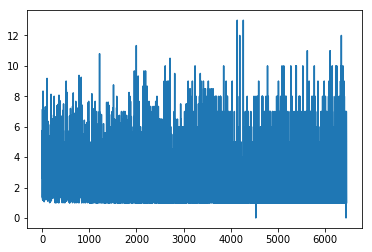

In [149]:
arr = []
for i in author_statistics:
    arr.append(np.sum(i*np.arange(14))/np.sum(i))

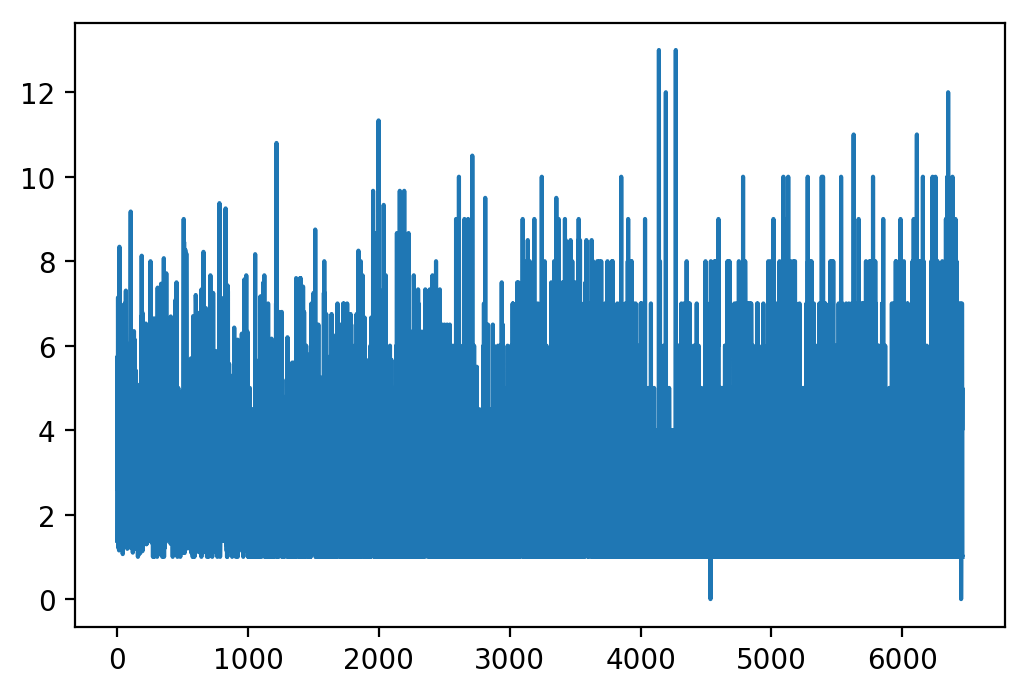

In [151]:
plt.figure(dpi = 200)
plt.plot(arr)

In [125]:
sum_prob = 0
for key in sorted(author_dictionary, key = author_dictionary.get, reverse = True):
    sum_prob += author_dictionary[key]
    print('%s created %s MoonBoard problem. cumulative number of problems = %s' %(key, author_dictionary[key], sum_prob))

Adan_vive created 364 MoonBoard problem. cumulative number of problems = 364
Riccardo Caprasecca created 329 MoonBoard problem. cumulative number of problems = 693
Kyle Knapp created 309 MoonBoard problem. cumulative number of problems = 1002
Kilgour22 created 296 MoonBoard problem. cumulative number of problems = 1298
Gus Carter created 282 MoonBoard problem. cumulative number of problems = 1580
Strato Sfera created 214 MoonBoard problem. cumulative number of problems = 1794
simone antuzzi created 179 MoonBoard problem. cumulative number of problems = 1973
Austin hoyt created 169 MoonBoard problem. cumulative number of problems = 2142
PJMOONCLIMBS created 164 MoonBoard problem. cumulative number of problems = 2306
akihiro ishii created 151 MoonBoard problem. cumulative number of problems = 2457
Corey Zee created 147 MoonBoard problem. cumulative number of problems = 2604
Nick Tatum created 146 MoonBoard problem. cumulative number of problems = 2750
Rodope created 127 MoonBoard problem

In [94]:
repeats_statistics_arr = np.array(repeats_statistics)

In [100]:
np.sum(repeats_statistics_arr == 0)

5525

In [157]:
MoonBoard_2016_raw['302944']

{'url': 'https://moonboard.com/Problems/View/302944/organ-donor-soup',
 'start': [[8, 3]],
 'mid': [[5, 6], [2, 7], [4, 11], [5, 12], [8, 14]],
 'end': [[10, 17]],
 'grade': '7C+',
 'user_grade': None,
 'is_benchmark': False,
 'repeats': 6,
 'problem_type': None,
 'is_master': False,
 'setter': {'Id': 'D834ECC8-36E4-4D77-A042-F263C95CB5E9',
  'Nickname': 'Sam McQueen',
  'Firstname': 'Sam',
  'Lastname': 'McQueen',
  'City': 'Sunnyvale',
  'Country': 'USA',
  'ProfileImageUrl': '/Content/Account/Images/default-profile.png?637231599110641484',
  'CanShareData': True}}

In [110]:
'337903' in MoonBoard_2016_raw

True